# **Linear Regression II**

---

### **Introduction**
This notebook goes over the basics of linear regression.

---

### **Author**
**Junichi Koganemaru**  

---

### **References**
1. Elements of Statistical Learning by Trevor Hastie, Robert Tibshirani, and Jerome Friedman.
2. Introduction to Statistical Learning by Gareth James, Daniela Witten, Trevor Hastie, and Robert Tibshirani.
3. All of Statistics: A Concise Course in Statistical Inference by Larry Wasserman.

---

### **Recommended Reading and Resources**

1. [Training, validation, and test sets](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets)
2. [Cross-Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics))
3. [Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion)
4. [Ridge Regression](https://en.wikipedia.org/wiki/Ridge_regression)
5. [Lasso Regression](https://en.wikipedia.org/wiki/Lasso_(statistics))
6. [Elastic Net](https://en.wikipedia.org/wiki/Elastic_net_regularization)
7. [Robust Regression](https://en.wikipedia.org/wiki/Robust_regression)
8. [Cook's distance](https://en.wikipedia.org/wiki/Cook%27s_distance)

---

### **Last Updated**
**February 3, 2025**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
from matplotlib.lines import Line2D 

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


## Model assessment and selection


In practice, there is often a tradeoff between model complexity and model performance. A model that is too simple may not capture the underlying structure of the data, while a model that is too complex may overfit.

In the context of linear regression, typically the more features are included in the model, the more likely it is to overfit. As a result, *model assessment and selection* is an important step in the modeling process to find a model that *generalizes* well to new data. The main goal of this process is to ultimately improve *predictive accuracy* and *model interpretability*.


## Data splitting 

One common approach to model assessment and selection is to first split the data into two parts: a *training set*, and a *test set*. The *training set* is a subset of the original data used to fit models and compare candidates, while the *testing set* is used to evaluate the model's performance on unseen data. This approach allows one to estimate how well the model will perform on unseen data. A fairly standard ratio is to choose 80% of the data for training and 20% for testing.


### Single validation set

A simple approach to comparing candidate models is to further split the training set into two parts, where one subset is used strictly for training, and the other is used for validation. 
<p align="center">
    <img src="../notes/diagrams/validation.png" alt="Validation Set" width="600">
</p>

Typically the validation set is chosen to be around 10-20% of the training set. The candidate models are fit on the training set, and then evaluated on the validation set. The model that performs the best on the validation set is chosen as the final model, and then the final model is evaluated on the test set to estimate its performance on unseen data.

The best model in this setting is the one that performs the best on the validation set. This approach is known as the *validation set* approach.

In ``scikit-learn``, the ``train_test_split`` function can be called to perform this task. Below we give a quick demo.

In [ ]:
california_housing = fetch_california_housing(as_frame=True)
df = california_housing.frame
df.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


In [3]:
X = df.drop(columns=['MedHouseVal'])
y = df['MedHouseVal']
print(X.shape)
print(y.shape)

(20640, 8)
(20640,)


In [4]:


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.2)

In [5]:
print("X_train dimensions:", X_train.shape)
print("y_train dimensions:", y_train.shape)

print("X_test dimensions:", X_test.shape)
print("y_test dimensions:", y_test.shape)

X_train dimensions: (16512, 8)
y_train dimensions: (16512,)
X_test dimensions: (4128, 8)
y_test dimensions: (4128,)


The main drawback of this approach is that it only validates the performance of the model once, the model's performance can be sensitive to how the data is split. A more robust validation framework is known as *cross-validation*.

### $k$-fold cross-validation

The simplest version of cross-validation splits the data into $k$ roughly equal-sized *folds*. The model is trained on $k-1$ of the folds, and then evaluated on the remaining fold. This process is repeated $k$ times, with each fold being used as the validation set exactly once. The performance of the model is then averaged over the $k$ folds to obtain an estimate of the model's performance.

<p align="center">
    <img src="../notes/diagrams/cross-validation.png" alt="Validation Set" width="600">
</p>



The most common choice for $k$ is 10. However, there are situations where $k$-fold validation is not feasible, as it requires the model to be trained $k$ times. This is typical when training large models (e.g. neural networks) over large datasets. In these cases, the single validation set approach is often used.

### Stratification 

In practice, sometimes it is important to make sure that the distribution of the target variable is the same in the training and test sets. For example, if one is building a classifier and the target variable is binary, if the training set does not have sufficient amount of one of the classes then the model may not be able to accurately predict that class on testing data.

*Stratification* is a method that ensures that the distribution of the target variable is the same in both the training and test sets. 

In ``scikit-learn``, stratification can be performed by passing the target variable to the ``stratify`` argument in the ``train_test_split`` function. For $k$-fold validation, the ``StratifiedKFold`` class can be used to perform stratified $k$-fold cross-validation.

### Akaike Information Criterion (AIC)

Given a model with a likelihood function, the Akaike Information Criterion (AIC) gives an alternative method for model selection. The AIC is defined as:
$$
\text{AIC} = - 2\log(L(\hat{\theta}_{\text{MLE}})) + 2p ,
$$
where $p$ is the number of parameters in the model and $L(\hat{\theta}_{\text{MLE}})$ is the maximal value of the likelihood function of the model. 

Since an increase in the number of parameters $p$ will typically lead to an increase in likelihood function $L$, the $-2\log L$ term will decrease. On the other hand, the $2p$ term acts as a penalty term for penalizing an increase in the number of parameters, so the AIC criterion seeks to balance the trade-off between model complexity and model fit.

In practice, the model with the smallest AIC is chosen as the best model; the absolute value of AIC is not important, only the relative values of AIC is used for comparing different models. The theoretical justification for AIC is based on [information theory](https://en.wikipedia.org/wiki/Information_theory).

Other similar criteria include the Bayesian Information Criterion (BIC) and the Mallows' $C_p$ criterion.

The AIC criterion can be implemented in a fairly straightforward manner in Python. Alternatively, the ``statsmodels`` library has a built-in function for computing AIC.

In [6]:
n_samples = 100
X = np.random.randn(n_samples, 5)
beta = np.array([1.5, -2.0, 3.0, 0.0, 0.0])
y = X @ beta + np.random.randn(n_samples) * 0.5

df = pd.DataFrame(X, columns=['X1', 'X2', 'X3', 'X4', 'X5'])
df['y'] = y
df.head(10)

,X1,X2,X3,X4,X5,y
0,0.545968,1.414299,-0.290392,0.762987,0.341274,-3.301739
1,-1.348709,-0.507276,1.310302,-0.076496,0.761630,3.972118
2,0.747220,0.071327,-1.738058,-0.346448,-0.001244,-4.036417
3,-1.633240,-1.553249,-1.190161,-0.478236,-1.565070,-3.635951
4,-1.271931,-0.955585,1.446766,0.142178,-0.220303,4.020419
5,-0.075241,-0.360154,-1.584902,-1.759946,-0.178189,-4.458068
6,-1.615221,0.501908,0.794840,-0.842378,-0.531055,-1.241985
7,-0.593039,-0.296573,0.189184,0.326650,0.207767,-0.056842
8,-0.663808,-0.999725,-0.779956,1.503665,0.635984,-2.129827
9,-0.228593,0.349090,-1.204576,-0.815551,0.032820,-4.893664


In [7]:
X_train = df[['X1', 'X2', 'X3']]
y_train = df['y']

model_sklearn = LinearRegression(fit_intercept=True).fit(X_train, y_train)
y_pred = model_sklearn.predict(X_train)

n = len(y_train)
rss = np.sum((y_train - y_pred) ** 2)
k = X_train.shape[1] + 1  
aic_sklearn = n * np.log(rss / n) + n * (1 + np.log(2 * np.pi)) + 2 * k
print(f"AIC: {aic_sklearn}")

AIC: 150.28265122291674


In [8]:
X_train_sm = sm.add_constant(X_train)  
model_sm = sm.OLS(y_train, X_train_sm).fit()
aic_sm = model_sm.aic
print(f"AIC: {aic_sm}")

AIC: 150.28265122291677


## Subset selection

Recall that in the standard linear regression model, we assume that there is a target variable $y$ and $p$ features and the relationship between them is 
$$
\boldsymbol{y} = \beta_0 + \beta_1 \boldsymbol{X}_1 + \beta_2 \boldsymbol{X}_2 + \ldots + \beta_p \boldsymbol{X}_p + \boldsymbol{\epsilon},
$$
where we assume $\boldsymbol{\epsilon} \sim N(\boldsymbol{0}, \sigma^2 I)$. 

There are a few reasons as to why one might want to perform *subset selection*:

1. Sometimes, not all $p$ features are associated to the target variable, which means that including all the features can lead to a poor performing model. 
2. Least squares estimators often have low bias but high variance, which means that *prediction accuracy* can be improved by reducing the number of features. In terms of the bias-variance tradeoff, one is essentially trading off a little bit of bias to reduce the variance of the model, improving overall prediction accuracy. 
3. Reducing the number of features can also improve the *interpretability* of the model. Determining a smaller subset that exhibit the most predictive power can help give a "big picture" view of the data.

In such cases, it is useful to perform *subset selection* to identify the subset of features that are most relevant to the target variable. 

Below we list a few common approaches. 


### Exhaustive search
In the case when $p$ is small, an *exhaustive search* over all possible models can be performed. In this case, one considers all $\binom{p}{1} + \binom{p}{2} + \ldots + \binom{p}{p} = 2^p$ possible models and selects the best one based on some criterion. Here are the typical steps:

1. One starts with a model $\mathcal{M}_0$ that includes no features. This is a baseline model that simply uses the sample mean to predict the target variable.

2. For $k= 1, ..., p$, fit all $\binom{p}{k}$ models with exactly $k$ predictors, and pick the best performing model $\mathcal{M}_k$ with respect to some metric (MSE, $R^2$, etc.) over a validation set or use cross-validation.

3. Among $\mathcal{M}_0, ..., \mathcal{M}_p$, select the best model based on some criterion (MSE over unseen validation set, k-fold cross-validation, AIC, adjusted $R^2$ etc.)

The adjusted $R^2$ is defined via 
$$
\text{Adjusted } R^2 = 1 - \frac{\text{RSS}/(n-k-1)}{\text{TSS}/(n-1)},
$$
where $n$ is the number of observations and $k$ is the number of predictors in the model. One can show that maximizing the adjusted $R^2$ is equivalent to minimizing $\frac{\text{RSS}}{n-k-1}$, and the idea is that the adjusted $R^2$ penalizes the addition of unnecessary predictors to the model, so it is a useful metric for feature selection. 

### Forward stepwise selection

When $p$ is large, the exhaustive search is not feasible. In this case, one can use *forward stepwise selection*, which is an example of a greedy algorithm. The idea is to start with a model that includes no features, and then add one feature at a time to the model. At each step, the feature that gives the best improvement in the model's performance is added to the model. This process is repeated until some stopping criterion is met.

1. Start with a baseline model $\mathcal{M}_0$ that includes no features.

2. For $k= 1, ..., p$:
    - Consider all models that add one of the remaining $p-k$ features to the model $\mathcal{M}_{k-1}$.
    - Choose the best model $\mathcal{M}_k$ among these $p-k$ models based on some criterion (MSE, $R^2$, etc.) over a validation set or using cross-validation.

3. Among $\mathcal{M}_0, ..., \mathcal{M}_p$, select the best model based on some criterion (MSE over unseen validation set, k-fold cross-validation, AIC, adjusted $R^2$, etc.).

### Backward stepwise selection

Similar to forward stepwise selection, *backward stepwise selection* starts with the full model and then removes one feature at a time. At each step, the feature that gives the best improvement in the model's performance is removed from the model. This process is repeated until some stopping criterion is met. 

Hybrid approaches that combine forward and backward stepwise selection with advanced pruning techniques are also available. 


## Shinkage methods/Regularization

Another approach to model selection is to use *shrinkage methods*, which are a class of techniques that can be used to reduce the complexity of a model by *shrinking* the coefficients of the features towards zero. One starts with a model that includes all $p$ features, and then the coefficients are estimated by minimizing modified loss functions that include a penalty term that penalizes the size of the coefficients.

The most common shrinkage methods are *ridge regression* and *lasso regression*.

### Ridge regression

Ridge regression is a shrinkage method that adds a penalty term to the least squares loss function. The ridge regression estimator is defined as the solution to the following optimization problem:
$$
\hat{\boldsymbol{\beta}}_{\text{ridge}} = \arg \min_{\boldsymbol{\beta}} \left\{ \|\boldsymbol{y} - X\boldsymbol{\beta}  \|_2^2 + \lambda \| \boldsymbol{\beta} \|_2^2 \right\} 
$$
where $\lambda > 0$ is a hyperparameter that controls the amount of shrinkage. We have seen on the homework that the ridge regression estimator can be written in closed form as
$$
\hat{\boldsymbol{\beta}}_{\text{ridge}} = (X^TX + \lambda I)^{-1}X^T\boldsymbol{y},
$$
where the matrix $X^TX + \lambda I$ is guaranteed to be invertible as long as $\lambda > 0$.

### Lasso regression

Lasso regression is another shrinkage method that adds a penalty term to the least squares loss function. The lasso regression estimator is defined as the solution to the following optimization problem:
$$
\hat{\boldsymbol{\beta}}_{\text{lasso}} = \arg \min_{\boldsymbol{\beta}} \left\{ \|\boldsymbol{y} - X\boldsymbol{\beta}  \|_2^2 + \lambda \| \boldsymbol{\beta} \|_1 \right\}
$$
where $\lambda > 0$ is a hyperparameter that controls the amount of shrinkage. The lasso regression estimator does not have a closed form expression, however it can be proved that it exists. In practice, the lasso regression estimator can be approximated using optimization algorithms.

### Elastic net

The elastic net is a hybrid of ridge and lasso regression that adds both $L_1$ and $L_2$ penalties to the least squares loss function. The elastic net estimator is defined as the solution to the following optimization problem:
$$
\hat{\boldsymbol{\beta}}_{\text{elastic}} = \arg \min_{\boldsymbol{\beta}} \left\{ \|\boldsymbol{y} - X\boldsymbol{\beta}  \|_2^2 + \lambda_1 \| \boldsymbol{\beta} \|_1 + \lambda_2 \| \boldsymbol{\beta} \|_2^2 \right\}
$$
where $\lambda_1, \lambda_2 > 0$ are hyperparameters that control the amount of shrinkage. Similar to the lasso regression estimator, the elastic net estimator also does not have a closed form expression, however it can be shown to exist and can be approximated using optimization algorithms.


### Geometry of regularization methods

As a warm-up, we first consider the definition of the *p-norm* or $L^p$-norm of a vector in $\mathbb{R}^n$. The norm is defined via 
$$
\| \boldsymbol{x} \|_p = \left( \sum_{i=1}^n |x_i|^p \right)^{1/p}, \; 1 \le p < \infty.
$$
One can also define the *infinity-norm* or $L^\infty$ norm via
$$
\| \boldsymbol{x} \|_\infty = \max_{1 \le i \le n} |x_i|.
$$

Note that the $L^2$ norm is the Euclidean norm. By plotting the unit circle w.r.t. different $p$-values, we can get an idea behind the geometry of the $L^p$-norms.


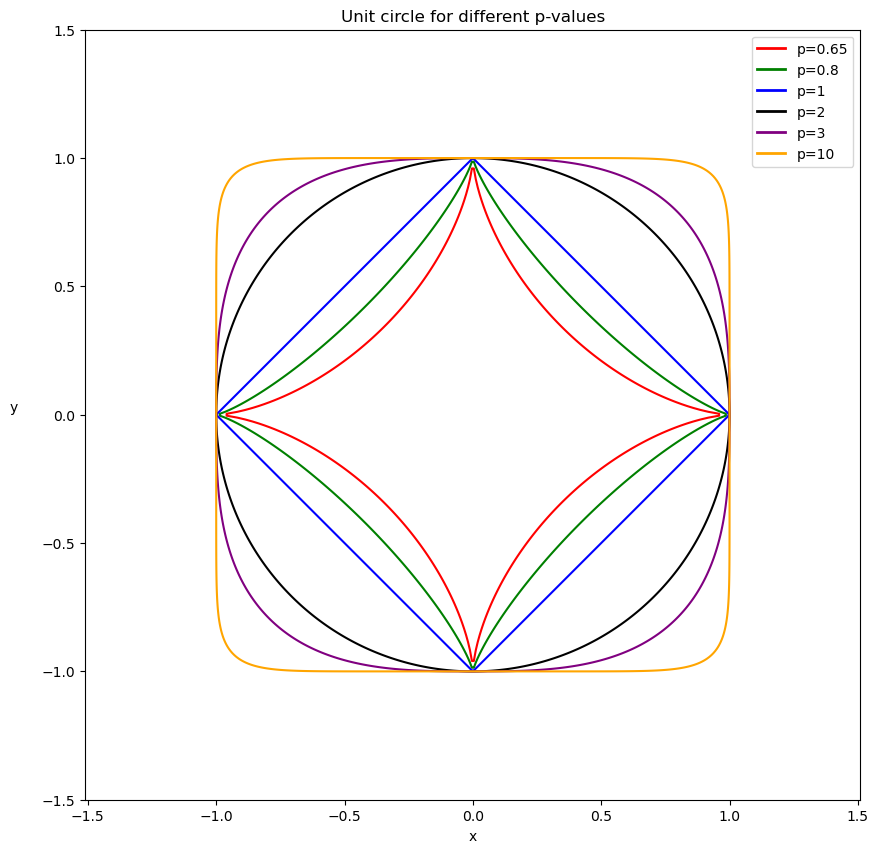

In [9]:
def p_norm(x, y, p):
    return (np.abs(x)**p + np.abs(y)**p)**(1/p)

# Note: p < 1 actually does not define a norm, we will discuss this later when we talk about normed spaces

p_values = [0.65, 0.8, 1, 2, 3, 10]
colors = ['red', 'green', 'blue', 'black', 'purple','orange']

x = np.linspace(-1.5, 1.5, 400)
y = np.linspace(-1.5, 1.5, 400)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(10, 10))
legends = [] 

for p, color in zip(p_values, colors):
    Z = p_norm(X, Y, p)
    plt.contour(X, Y, Z, levels=[1], colors=[color])

    legend = Line2D([0], [0], color=color, lw=2, label=f'p={p}')
    legends.append(legend)

plt.xlabel('x')
plt.ylabel('y', rotation = 0, labelpad=20)
plt.title('Unit circle for different p-values')

plt.legend(handles=legends)
plt.axis('equal')
plt.show()


The reason why this picture is useful is that one can show both ridge and lasso estimators can be interpreted as solutions to *constrained optimization* problems. In particular, for every $\lambda$, there exists a $t$ such that 
$$
\hat{\boldsymbol{\beta}}_{\text{ridge}} = \arg \min_{\boldsymbol{\beta}} \left\{ \|\boldsymbol{y} - X\boldsymbol{\beta}  \|_2^2 \right\} \quad \text{subject to} \quad \|\boldsymbol{\beta}\|_2^2 \leq t
$$
and 
$$
\hat{\boldsymbol{\beta}}_{\text{lasso}} = \arg \min_{\boldsymbol{\beta}} \left\{ \|\boldsymbol{y} - X\boldsymbol{\beta}  \|_2^2 \right\} \quad \text{subject to} \quad \|\boldsymbol{\beta}\|_1 \leq t.
$$

The heuristic is that large $\lambda$ corresponds to small $t$ and vice versa.

This implies that we can make the following geometric interpretation: the ridge regression estimator is the point on the $n$-dimensional sphere that is closest to the least squares estimate with respect to the $L^2$ norm, whereas the lasso regression estimator is the point on the $n$-dimensional diamond that is closest to the least squares estimate with respect to the $L^1$ norm.

The following diagram is from Chapter 3 of Elements of Statistical Learning.

<p align="center">
    <img src="../notes/diagrams/ridge-lasso-ESL.png" alt="Ridge and Lasso" width="800">
</p>


We note that the standard error is quadratic in $\boldsymbol{\beta}: \| \boldsymbol{y} - X \boldsymbol{\beta}\|_2^2 = \boldsymbol{\beta}^T X^T X \boldsymbol{\beta} - 2 \boldsymbol{\beta}^T X^T \boldsymbol{y} + \boldsymbol{y}^T \boldsymbol{y}$. The leading term is $\boldsymbol{\beta}^T X^T X \boldsymbol{\beta} $, which suggests that the level sets of the standard loss function are ellipsoids. This is why the red contours are ellipsoids in the diagram above.

The way to interpret the diagram is that the least squares estimate is the point at the center of the ellipsoids as it corresponds to the minimum of the quadratic form. Both ridge and lasso regression estimators are constrained to lie on the boundary of the ellipsoid or diamond, respectively; the first point of contact is then the closest point to the least squares estimate.

Here is a nice consequence of understanding this geometrically: due to the geometry of the unit ball with respect to the $L^1$ norm, the lasso regression estimator is more likely to produce *sparse* solutions, i.e. solutions where many of the coefficients are zero. This is in contrast to the ridge regression estimator, which tends to shrink the coefficients towards zero but does not typically set them to zero. In particular, this means that the lasso regression estimator can be used for feature selection.

Below we give a quick demo based on synthetic data. We use model with 10 features, the first 3 are the dominant features, the next 3 are collinear, and the rest are noise. We then fit the model using ridge and lasso regression and compare the coefficients.

In [10]:
n_samples = 100

X_dominant = np.random.randn(n_samples, 3)
true_coefs_dominant = np.array([3, 5, -2])

X_collinear = np.repeat(np.random.randn(n_samples, 1), 3, axis=1) + 0.01 * np.random.randn(n_samples, 3)
X_noise = np.random.randn(n_samples, 4)

X = np.hstack([X_dominant, X_collinear, X_noise])

true_coefs = np.zeros(10)
true_coefs[:3] = true_coefs_dominant

y = X_dominant.dot(true_coefs_dominant) + np.random.randn(n_samples) * 1.0

df = pd.DataFrame(X, columns=[f'Feature {i+1}' for i in range(X.shape[1])])
df['y'] = y
df.head(10)

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,y
0,1.222266,1.670717,1.052925,-1.270085,-1.254838,-1.267874,0.426267,0.266997,1.327976,0.033481,10.477315
1,0.882407,-0.532097,1.441253,0.732871,0.725196,0.723064,0.001868,2.174628,-1.941917,-2.126647,-1.936725
2,-0.178559,-0.931337,0.622248,-0.767981,-0.772938,-0.748600,-1.485549,-0.153248,-1.826529,0.382810,-5.919978
3,-1.877488,-0.315991,0.163628,0.194732,0.175936,0.175969,-0.497406,-0.790328,-0.989003,1.881313,-7.407835
4,0.685434,-1.872608,-0.224645,1.585439,1.576516,1.582458,0.590323,-1.081134,1.453885,-0.903682,-7.317265
5,1.348332,-0.674970,0.653236,-0.671028,-0.682138,-0.674344,-0.504207,-0.438586,0.500065,2.244190,-2.322668
6,-1.323359,0.053614,-1.471372,-0.605428,-0.589888,-0.612320,1.329902,0.013530,0.728005,-0.034011,-0.453223
7,0.027998,-0.353704,-0.289986,0.962370,0.963089,0.978487,0.113964,1.313345,1.790461,-1.649797,-1.597491
8,0.817351,-1.024276,0.327893,1.567107,1.562774,1.581898,-2.134978,-0.725083,0.640870,0.558340,-3.141837
9,-0.032273,-0.141015,0.002154,0.454875,0.473564,0.468878,0.724570,-1.021917,-1.176869,0.955666,-0.468442


In [11]:
reg = LinearRegression().fit(X, y)
coefs_ols = reg.coef_

# Note: in scikit-learn, they use alpha instead of lambda to denote the regularization strength

ridge_fixed = Ridge(alpha=1).fit(X, y)
coefs_ridge_fixed = ridge_fixed.coef_

lasso_fixed = Lasso(alpha=0.1, max_iter=10000).fit(X, y)
coefs_lasso_fixed = lasso_fixed.coef_

print("True coefficients:")
print(true_coefs)
print("\nOLS coefficients:")
print(coefs_ols)
print("\nRidge coefficients (lambda=1.0):")
print(coefs_ridge_fixed)
print("\nLasso coefficients (lambda=0.1):")
print(coefs_lasso_fixed)

True coefficients:
[ 3.  5. -2.  0.  0.  0.  0.  0.  0.  0.]

OLS coefficients:
[ 2.98124979  5.14682683 -1.9866977   0.84768876  5.09517044 -5.99963637
 -0.00985089  0.02808996  0.00677988 -0.03470117]

Ridge coefficients (lambda=1.0):
[ 2.94459655  5.08666325 -1.9512451  -0.02332287  0.0413262  -0.07696868
 -0.00695409  0.04016946  0.02593137 -0.02300291]

Lasso coefficients (lambda=0.1):
[ 2.87314428  5.04972661 -1.84828719 -0.         -0.         -0.
  0.          0.          0.         -0.        ]


In [12]:
lambda_values = np.logspace(-2, 2, 10) 

ridge_coefs = []
lasso_coefs = []

for lam in lambda_values:
    ridge_model = Ridge(alpha=lam)
    ridge_model.fit(X, y)
    ridge_coefs.append(ridge_model.coef_)
    
    lasso_model = Lasso(alpha=lam, max_iter=10000)
    lasso_model.fit(X, y)
    lasso_coefs.append(lasso_model.coef_)


feature_names = [f'Feature {i}' for i in range(10)]

ridge_df = pd.DataFrame(ridge_coefs, columns=feature_names)
ridge_df.insert(0, 'lambda value', lambda_values)

lasso_df = pd.DataFrame(lasso_coefs, columns=feature_names)
lasso_df.insert(0, 'lambda value', lambda_values)

In [13]:
ridge_df

,lambda value,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,0.010000,2.981101,5.142414,-1.982814,0.369060,2.742606,-3.168850,-0.011883,0.030227,0.007331,-0.030508
1,0.027826,2.980617,5.139544,-1.980538,0.172429,1.496587,-1.726458,-0.012730,0.031439,0.007897,-0.028355
2,0.077426,2.978891,5.135661,-1.977968,0.055251,0.653374,-0.766298,-0.012994,0.032549,0.008991,-0.026810
3,0.215443,2.973765,5.127797,-1.973497,0.002450,0.245637,-0.306019,-0.012298,0.033976,0.011639,-0.025716
4,0.599484,2.959422,5.107474,-1.962452,-0.018399,0.080186,-0.120241,-0.009702,0.037089,0.018716,-0.024270
5,1.668101,2.920208,5.052423,-1.932903,-0.026430,0.017565,-0.050934,-0.002458,0.045159,0.037653,-0.021011
6,4.641589,2.816678,4.906136,-1.855618,-0.030107,-0.006364,-0.026884,0.015965,0.065668,0.085505,-0.013044
7,12.915497,2.565653,4.544004,-1.671380,-0.033273,-0.017574,-0.021267,0.055753,0.111047,0.188512,0.003754
8,35.938137,2.062660,3.783081,-1.315014,-0.037955,-0.026666,-0.025291,0.113550,0.180986,0.336258,0.027074
9,100.000000,1.345704,2.602841,-0.834236,-0.042907,-0.035483,-0.033559,0.141434,0.219821,0.399384,0.037710


In [14]:
lasso_df

,lambda value,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,0.010000,2.971631,5.130779,-1.964717,-0.013508,-0.0,-0.037355,-0.00153,0.025906,0.001495,-0.01769
1,0.027826,2.951369,5.116026,-1.940204,-0.036654,-0.0,-0.001784,-0.00000,0.016066,0.000000,-0.00000
2,0.077426,2.898645,5.071418,-1.876403,-0.002607,-0.0,-0.000467,0.00000,0.000000,0.000000,-0.00000
3,0.215443,2.741792,4.937930,-1.706304,-0.000000,-0.0,-0.000000,0.00000,0.000000,0.000000,0.00000
4,0.599484,2.304827,4.566022,-1.233974,-0.000000,-0.0,-0.000000,0.00000,0.000000,0.000000,0.00000
5,1.668101,1.090950,3.532595,-0.000000,-0.000000,-0.0,-0.000000,0.00000,0.000000,0.000000,0.00000
6,4.641589,0.000000,0.789411,-0.000000,-0.000000,-0.0,-0.000000,0.00000,0.000000,0.000000,0.00000
7,12.915497,0.000000,0.000000,-0.000000,-0.000000,-0.0,-0.000000,0.00000,0.000000,0.000000,0.00000
8,35.938137,0.000000,0.000000,-0.000000,-0.000000,-0.0,-0.000000,0.00000,0.000000,0.000000,0.00000
9,100.000000,0.000000,0.000000,-0.000000,-0.000000,-0.0,-0.000000,0.00000,0.000000,0.000000,0.00000


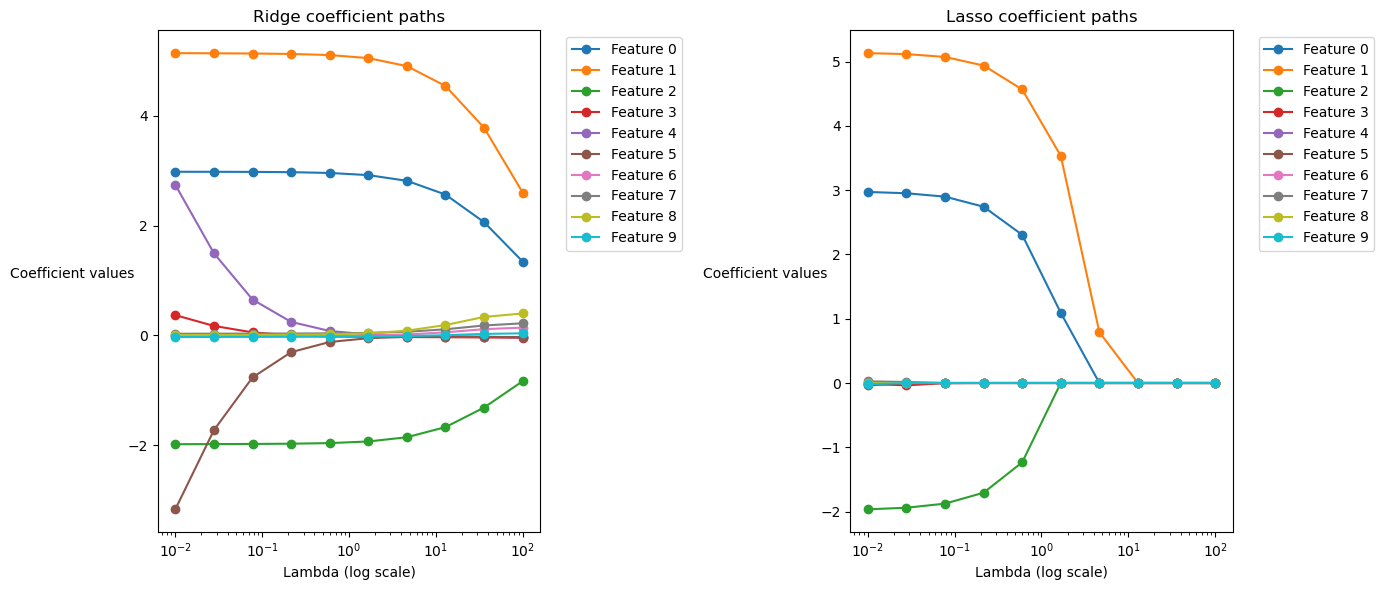

In [15]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for feature in feature_names:
    plt.plot(lambda_values, ridge_df[feature], marker='o', label=feature)
plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Coefficient values', rotation=0, labelpad=40)
plt.title('Ridge coefficient paths')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(1, 2, 2)
for feature in feature_names:
    plt.plot(lambda_values, lasso_df[feature], marker='o', label=feature)
plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Coefficient values', rotation=0, labelpad=40)
plt.title('Lasso coefficient paths')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Principal components regression

We saw in the previous demo that standard regression methods can perform poorly when there are *correlated features* in the data. In statistics, this is referred to as *multicollinearity*. One way to address multicollinearity is to use *principal components regression*.

The idea is fairly simple: perform PCA on the features and use this to obtain *derived input features* that are uncorrelated. The derived features can then be used as inputs into other regression models.

### Ridge and SVD/PCA

One can also show that the ridge regression estimator can be written in terms of the singular value decomposition (SVD) of the design matrix $X$. In particular, if $X = U \Lambda V^T$ is the SVD of $X$, then the ridge regression estimator satisfies
$$
X \hat{\boldsymbol{\beta}}_{\text{ridge}} = X (X^T X + \lambda I)^{-1} X^T \boldsymbol{y} = U \Lambda  (\Lambda ^2 + \lambda I)^{-1} \Lambda  U^T \boldsymbol{y} = \sum_{i=1}^p  \frac{\sigma_i^2}{\sigma_i^2 + \lambda}  (\boldsymbol{y} \cdot \boldsymbol{u}_i  ) \boldsymbol{u}_i ,
$$
where $\sigma_i$ are the singular values of $X$ and $\boldsymbol{u}_i$ are the corresponding left singular vectors.

From this computation we can deduce the following interpretation of Ridge regression in terms of the SVD: when one performs ridge regression, one first performs a change of basis to compute the coordinates of $\boldsymbol{y}$ in the basis of the left singular vectors of $X$. Then, one applies a shrinkage factor to each coordinate, and then transforms back to the original basis. 

We note that the shrinkage factor is given by $\frac{\sigma_i^2}{\sigma_i^2 + \lambda}$, which is always less than 1. In particular, the shrinkage is larger for smaller singular values, meaning that a greater amount of shrinkage is applied in the directions where the data has less variance. 

So similar to principal components regression, ridge regression can be thought of as a method that counters multicollinearity by shrinking the coefficients in the directions where the data has less variance, however the difference is that ridge is still preserving some signal in those directions whereas principal components regression throws them away entirely. 


## Outliers

Recall that in the standard least squares approach, one minimizes the function
$$
\text{RSS}(\boldsymbol{\beta}) = \sum_{i=1}^n (y_i - \boldsymbol{\beta} \cdot \boldsymbol{x}_i)^2.
$$
This is equivalent to minimizing 
$$
\frac{1}{\sigma^2} \text{RSS}(\boldsymbol{\beta}) = \sum_{i=1}^n \rho \left( \frac{y_i - \boldsymbol{\beta} \cdot \boldsymbol{x}_i }{\sigma} \right)
$$
for $\rho: \mathbb{R} \to \mathbb{R}$ given by $\rho(t) = t^2$. 

The advantage of this approach is that it is easy to analyze using tools from linear algebra. However, the least squares approach is sensitive to *outliers* in the data as $\rho$ places a lot of emphasis on extreme observations. This may be okay when the errors are normally distributed, but it is typically not very robust if this assumption is violated. For example, if the errors are heavy-skewed, then it is very likely for one to see a few extreme outliers in the data.

## Robust regression

A possible way to address this is to use a *robust loss function* that is less sensitive to outliers. A popular choice is the *Huber loss* function $\rho_{\text{Hub}}: \mathbb{R} \to \mathbb{R}$, which is defined via
$$
\rho_{\text{Hub}}(t) = \begin{cases} t^2 & \text{if } |t| \leq k, \\ 2k|t| - k^2 & \text{if } |t| > k, \end{cases}
$$
where $k$ is a hyperparameter that determines the point at which the loss function transitions from quadratic to linear. The default choice is $k = 1.345$. Note that as $k \to \infty$, the Huber loss function "approaches" the $L^2$ loss function; as $k \to 0$, the Huber loss function degenerates to the $L^1$ loss function, so one can think of the Huber loss function as an in-between loss function balancing between the $L^1$ and $L^2$ loss functions.

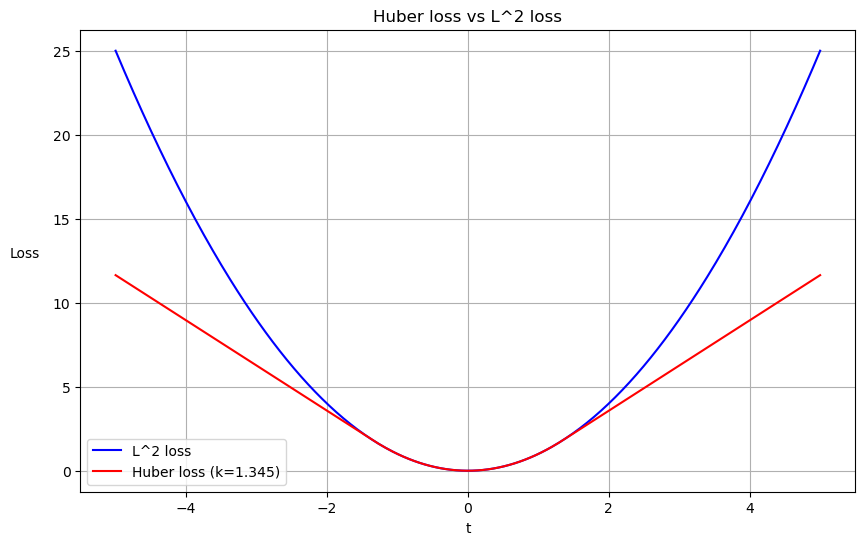

In [19]:
def huber_loss(t, k):
    return np.where(np.abs(t) <= k, t**2, 2*k*np.abs(t) - k**2)

k = 1.345
t = np.linspace(-5, 5, 400)
standard_loss = t**2
huber_loss_values = huber_loss(t, k)

plt.figure(figsize=(10, 6))
plt.plot(t, standard_loss, label='L^2 loss', color='blue')
plt.plot(t, huber_loss_values, label=f'Huber loss (k={k})', color='red')
plt.xlabel('t')
plt.ylabel('Loss', rotation=0, labelpad=20)
plt.title('Huber loss vs L^2 loss')
plt.legend()
plt.grid(True)
plt.show()

## Outlier detection

Another way to combat outliers is to detect them using an appropriate criterion. In some cases, outliers can be removed from the data to improve model performance, though sometimes modifying the model to be more robust to outliers is a better approach as outliers can sometimes contain useful information.

One popular way of detecting outliers is to use the *Cook's distance* criterion. The Cook's distance is defined as
$$
D_i = \frac{\sum_{j=1}^n (\hat{y}_j - \hat{y}_{j(i)})^2}{(p+1) \hat{\sigma}^2},
$$
where $\hat{y}_j$ is the $j$-th fitted value, $\hat{y}_{j(i)}$ is the $j$-th fitted value when the $i$-th observation is removed, $p$ is the number of predictors in the model, and $\hat{\sigma}^2$ is the sample variance.

The Cook's distance measures the influence of the $i$-th observation on the model. Typically if $D_i > 1$, then the $i$-th observation is considered an outlier.

Cook's distance does not actually need to be computed by removing observations, as one can show that in the case of linear regression. If we assume the design matrix $X$ is of full rank, then the Cook's distance can be written as

$$
D_j = \frac{\hat{\varepsilon}_j^2}{(p+1) \hat{\sigma}^2} \left( \frac{h_{jj}}{1-h_{jj}} \right),
$$

where $h_{jj}$ is the *leverage* of the $j$-th observation, which is a measure of how much the $j$-th observation influences the fit. The leverages are diagonal entries of the projection matrix $P = X(X^TX)^{-1}X^T$.

In Python, Cook's distance can be computed using ``holdlm.get_influence().cooks_distance`` where ``holdlm`` is from the ``statsmodels`` library.